<a href="https://colab.research.google.com/github/blackgreenc/AI/blob/main/%ED%99%94%ED%92%8D%EB%B3%80%ED%99%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from keras import optimizers
import keras
from tensorflow.keras.optimizers import schedules
print(tf.__version__)

2.6.0


In [4]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

In [7]:
from google.colab import files
style_image_001 = files.upload() # 가나가와 해변의 높은 파도 아래

Saving 가나가와 해변의 높은 파도 아래.jfif to 가나가와 해변의 높은 파도 아래.jfif


In [8]:
from tensorflow.python.keras.layers import Conv2D, BatchNormalization, Add, Activation

def residual_block(input_ts):
    #Residual Block을 구축하는 함수
    x = Conv2D(
        128, (3,3), strides = 1, padding = 'same'
    )(input_ts)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3,3), strides = 1, padding = 'same')(x)
    x = BatchNormalization()(x)
    return Add()([x, input_ts])

In [11]:
from tensorflow.python.keras.layers import Input, Lambda, Conv2DTranspose
from tensorflow.python.keras.models import Model

def build_encoder_decoder(input_shape = (224, 224, 3)):
    #변환용 네트워크 구축

    #인코더 부분
    input_ts = Input(shape=input_shape, name='input')

    #입력을 [0, 1]의 범위로 정규화
    x = Lambda(lambda a: a/255.)(input_ts)

    x = Conv2D(32, (9, 9), strides = 1, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    #Residual Block,  5 block add
    for _ in range(5):
        x = residual_block(x)

    # decoder part
    x = Conv2DTranspose(64, (3, 3), strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(32, (3, 3), strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(3, (9, 9), strides = 1, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)

    # 출력갑이 [0, 255]이 되도록 스케일 변환
    gen_out = Lambda(lambda a: (a + 1) * 127.5)(x)

    model_gen = Model(
        inputs = [input_ts],
        outputs = [gen_out]
    )

    return model_gen

input_shape = (224, 224, 3)

#변환 네트워크 구축

model_gen = build_encoder_decoder(
    input_shape = input_shape
)

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
from tensorflow.python.keras.applications.vgg16 import VGG16

# 사전 학습 model VGG16 호출
vgg16 = VGG16()

#가중치 파라미터를 학습하지 않도록 설정
for layer in vgg16.layers:
    layer.trainable = False


# VGG16을 위한 입력값 전처리 함수
def norm_vgg16(x):
    # RGB -> BGR 변환과 중심화를 실시하는 함수

    return (x[: :, :, ::-1] - 120)/255.

# 특징량을 추출하는 층의 이름 정의
style_layer_names = (
    'block1_conv2',
    'block2_conv2',
    'block3_conv3',
    'block4_conv3'
)

contents_layer_names = ('block3_conv3',)

#중간층의 출력을 보관하기 위한 리스트
style_outputs_gen = []
contents_outputs_gen = []

input_gen = model_gen.output #변환 네트워크의 출력을 입력으로

z = Lambda(norm_vgg16)(input_gen)
for layer in vgg16.layers:
    z = layer(z) # VGG16의 층을 쌓아 네트워크를 재구축
    if layer.name in style_layer_names:
        #스타일 특징량 추출용 중간층의 출력 추가
        style_outputs_gen.append(z)
    if layer.name in contents_layer_names:
        # 콘텐츠 특징량 추출용 중간층의 출력 추가
        contents_outputs_gen.append(z)

# model define
model = Model(
    inputs = model_gen.input,
    outputs = style_outputs_gen + contents_outputs_gen
)

553467904/553467096 [==============================] - 12s 0us/step


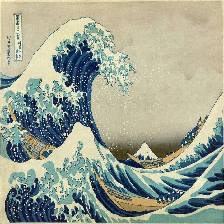

In [13]:
input_size = input_shape[:2]

# style image reading
img_sty = image.load_img(
    '가나가와 해변의 높은 파도 아래.jfif',
    target_size = input_size
)

# style image indication
img_sty



In [14]:
#읽어들인 이미지를 numpy.ndarray로 변환
img_arr_sty = np.expand_dims(image.img_to_array(img_sty), axis = 0)

In [15]:
#입력층 정의
input_sty = Input(shape=input_shape, name = 'input_sty')

style_outputs = [] # 중간층의 출력을 저장할 리스트
x = Lambda(norm_vgg16)(input_sty)

for layer in vgg16.layers:
    x = layer(x)
    if layer.name in style_layer_names:
        style_outputs.append(x)

# 스타일의 원본 이미지를 입력해서 특징량을 출력할 모델 정의
model_sty = Model(
    inputs = input_sty,
    outputs = style_outputs
)

# 원본 이미지에서 정답 데이터가 되는 특징량 추출
y_true_sty = model_sty.predict(img_arr_sty)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [16]:
#입력층 정의
input_con = Input(shape = input_shape, name = 'input_con')

contents_outputs = [] #중간층의 출력을 저장할 리스트
y = Lambda(norm_vgg16)(input_con)
for layer in vgg16.layers:
    y = layer(y)
    if layer.name in contents_layer_names:
        contents_outputs.append(y)




#컨텐츠의 원본 이미지를 입력해서 특징량을 추출하는 모델 정의
model_con = Model(
    inputs = input_con,
    outputs = contents_outputs
)

In [17]:
# 이미지 파일 불러오기용 래퍼 함수 정의
def load_imgs(img_paths, target_size=(224,224)):
    #이미지 파일 경로 리스트로부터, 배열의 배치를 반환
    _load_img = lambda x : img_to_array(
        load_img(x, target_size = target_size)
    )
    img_list = [
                np.expand_dims(_load_img(img_path), axis = 0)
                for img_path in img_paths
    ]
    return np.concatenate(img_list, axis = 0)

In [18]:
import math

def train_generator(img_paths, batch_size, model, y_true_sty, shuffle = True, epochs = None):
    # 학습 데이터를 생성하는 생성기
    n_samples = len(img_paths)
    indices = list(range(n_samples))
    steps_per_epoch = math.celi(n_samples / batch_size)
    img_paths = np.array(img_paths)
    cnt_epoch = 0
    while True:
        cnt_epoch += 1
        if shuffle:
            np.random.shuffle(indices)
        for i in range(step_per_epoch):
            start = batch_size*id
            end = baatch_size * (i + 1)
            X = load_imgs(img_paths[indices[start:end]])
            batch_size_act = X.shape[0]

            y_true_sty_t = [
                np.repeat(feat, batch_size_act, axis = 0)
                for feat in  y_true_sty
            ]
            #콘텐츠 특징량 추출
            y_true_con = model.predict(X)
            yield (X, y_true_sty_t + [y_true_con])
        if epochs is not None:
            if cnt_epoch >= epochs:
                raise StopIteration

In [19]:
import glob
import os

#입력 이미지 파일 경로 취득
path_glob = os.path.join('img/context/*.jpg')
img_paths = glob.glob(path_glob)

#배치사이즈와 epoch 설정
batch_size = 2
epochs = 10

# 생성기 생성 
gen = train_generator(
    img_paths, batch_size,
    model_con, y_true_sty,
    epochs = epochs
)

In [20]:
from tensorflow.python.keras import backend as K


def feature_loss(y_true, y_pred):
    # 콘텐츠 특징량 손실 함수
    norm = K.prod(K.cast(K.shape(y_true)[1:], 'float32'))
    return K.sum(
        K.square(y_pred = y_true), axis = (1,2,3)
    )/norm

In [21]:
def gram_matrix(X):
    # 그람 행렬 계산
    X_sw = K.permute_dimensions(
        X, (0,3,2,1)
    )# 축변환
    s = K.shape(X_sw)
    new_shape = (s[0], s[1], s[2], s[3])
    X_rs = K.reshape(X_sw, new_shape)
    X_rs_t = K.permute_dimensions(
        X_rs, (0,2,1)
    )#행렬을 전치
    dot = K.batch_dot(X_rs, X_rs_t) # 내적계산
    norm = K.prod(K.cast(s[1:], 'float32'))
    return dot/norm

def style_loss(y_true, y_pred):
    #스타일용 손실 함수 정의
    return K.sum(
        K.square(
            gram_matrix(y_pred) - gram_matrix(y_true)
        ),
        axis = (1,2)
    )

In [22]:
import datetime


#모델과 결과를 저장할 폴더 준비
dt = datetime.datetime.now()
dir_log = 'model/{:%y%m%d_%H%M%s}'.format(dt)
dir_weights = 'model/{:%y%m%d_%H%M%s}/weights'.format(dt)
dir_trans = 'model/{:%y%m%d_%H%M%s}/img_trans'.format(dt)

os.makedirs(dir_log, exist_ok=True)
os.makedirs(dir_weights, exist_ok=True)
os.makedirs(dir_trans, exist_ok=True)

In [23]:
# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 155013 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.2.2-3.1ubuntu0.7_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.2.2-3.1ubuntu0.7) ...
Setting up libarchive-dev:amd64 (3.2.2-3.1ubuntu0.7) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 154 kB 5.0 MB/s 
  Created wheel for libarchive: filename=libarchive-0.4.7-py3-none-any.whl size=31647 sha256=953ae62108633e93c00b5c481c9515b197520e650af4c708c532f2910c5271ee
  Stored in directory: /root/.cache/pip/wheels/63/b1/c6/b3da79bec2012175bd43603eed98ef8548ac1733b77c1d4330
Successfully built libarchive


In [24]:
model_loss = [ style_loss, style_loss, style_loss, style_loss, feature_loss]

In [36]:
from tensorflow.keras.optimizers import Adadelta

# model compile
model.compile(
    optimizer = Adadelta(),
    loss = [    
            style_loss, 
            style_loss, 
            style_loss, 
            style_loss, 
            feature_loss],
    loss_weights = [1.0, 1.0, 1.0, 1.0, 3.0]
)

ValueError: ignored

In [37]:
print(keras.__version__)


2.6.0
